In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [ ]:
df = pd.read_csv('model/student_habits_performance.csv')

In [3]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [4]:
df.shape

(1000, 16)

### Univariate Analysis

In [5]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [6]:
print("\n🔹 Numerical Columns:", num_cols)
print("🔹 Categorical Columns:", cat_cols)


🔹 Numerical Columns: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'exam_score']
🔹 Categorical Columns: ['student_id', 'gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [ ]:
fig = px.scatter_3d(
    df,
    x='study_hours_per_day',
    y='sleep_hours',
    z='exam_score',
    color='mental_health_rating',
    size='attendance_percentage',
    hover_data=['diet_quality', 'exercise_frequency'],
    title='🎓 How Lifestyle Habits Affect Exam Performance',
)
fig.update_layout(
    template='plotly_dark',
    title_font=dict(size=20, color='white'),
    scene=dict(
        xaxis_title='Study Hours per Day',
        yaxis_title='Sleep Hours',
        zaxis_title='Exam Score'
    )
)
fig.show()

In [20]:
fig = px.imshow(
    df[num_cols].corr(),
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='🔥 Correlation Heatmap Between Study Habits and Exam Performance'
)
fig.update_layout(
    template='plotly_dark',
    title_font=dict(size=18, color='white')
)
fig.show()


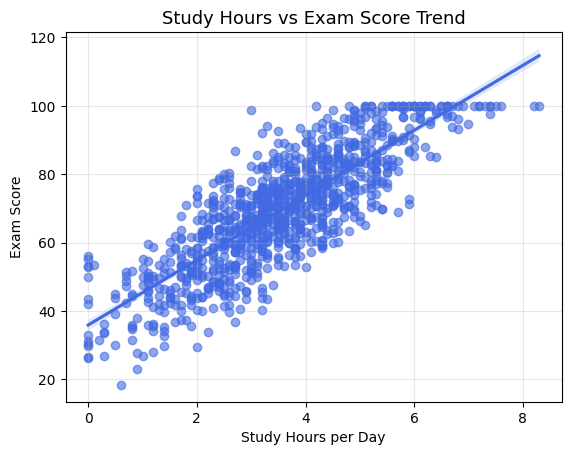

In [21]:
sns.regplot(x=df['study_hours_per_day'], y=df['exam_score'], color='royalblue', scatter_kws={'alpha':0.6})
plt.title('Study Hours vs Exam Score Trend', fontsize=13)
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')
plt.grid(alpha=0.3)
plt.show()


In [8]:
target = df['exam_score']

In [9]:
target_column_name = 'exam_score'
if target_column_name in df.columns:
    print(f"\n🔹 Target column selected: {target_column_name}")


🔹 Target column selected: exam_score


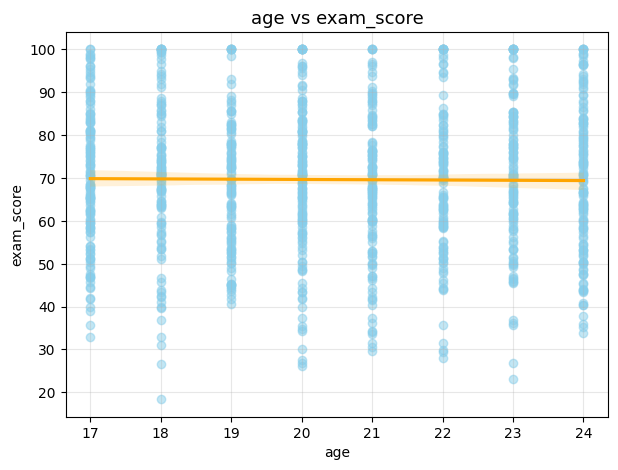

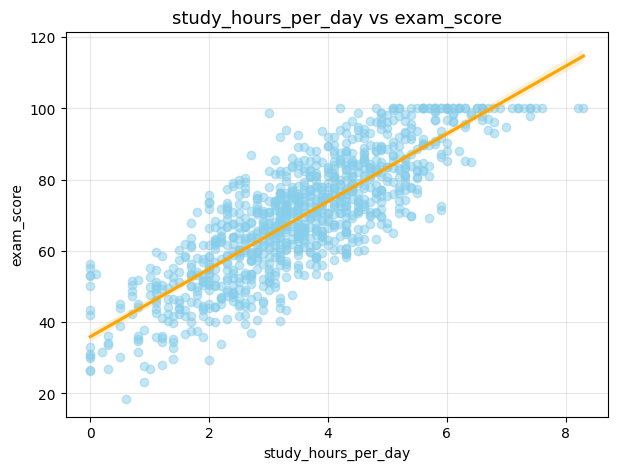

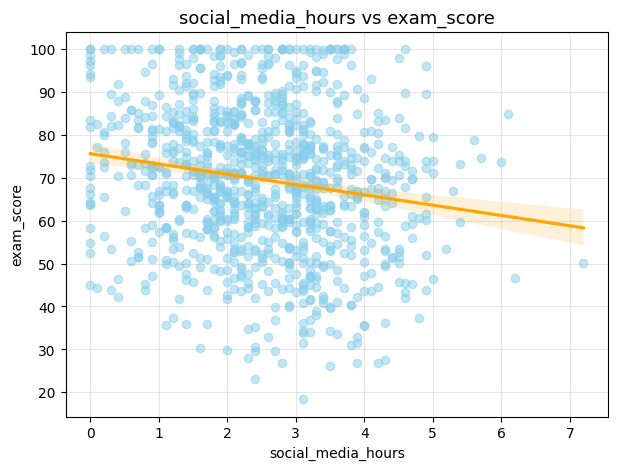

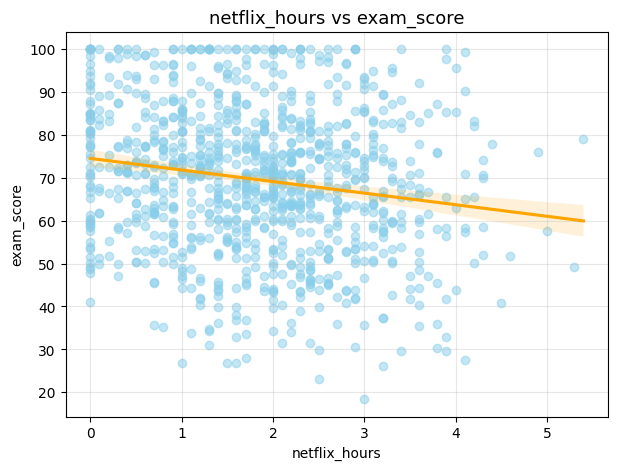

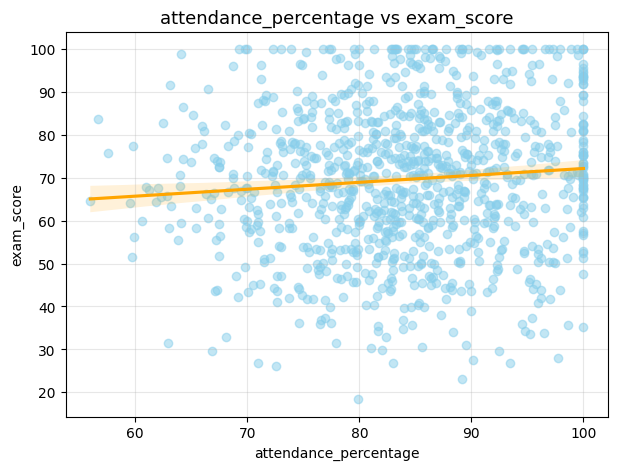

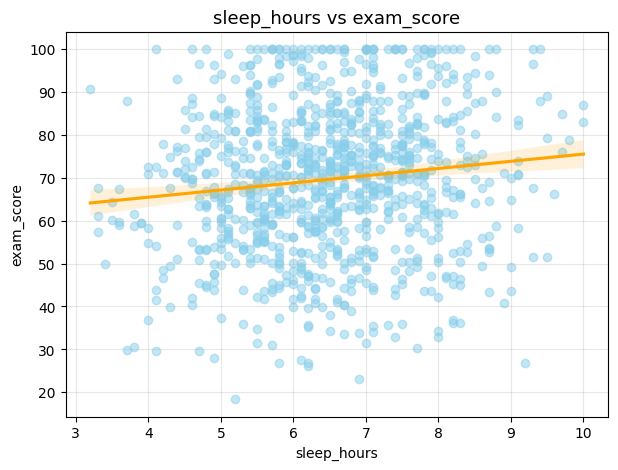

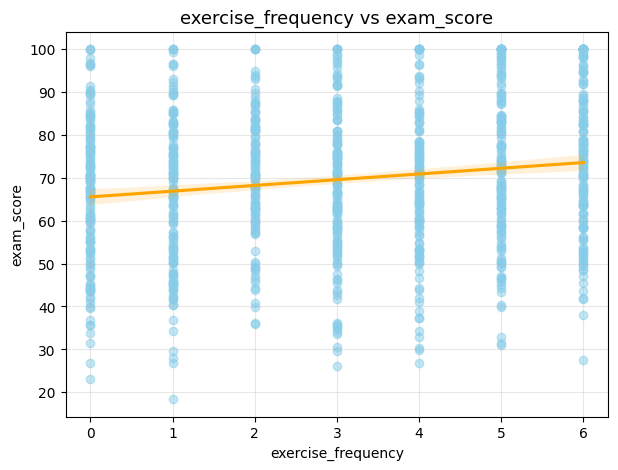

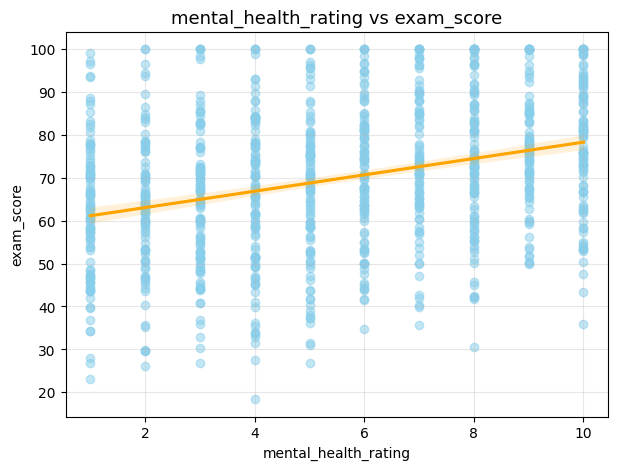

In [22]:
for col in num_cols:
    if col != target_column_name and col != 'student_id':
        plt.figure(figsize=(7,5))
        sns.regplot(
            x=df[col],
            y=df[target_column_name],
            scatter_kws={'alpha':0.5, 'color':'skyblue'},
            line_kws={'color':'orange'}
        )
        plt.title(f'{col} vs {target_column_name}', fontsize=13)
        plt.xlabel(col)
        plt.ylabel(target_column_name)
        plt.grid(alpha=0.3)
        plt.show()


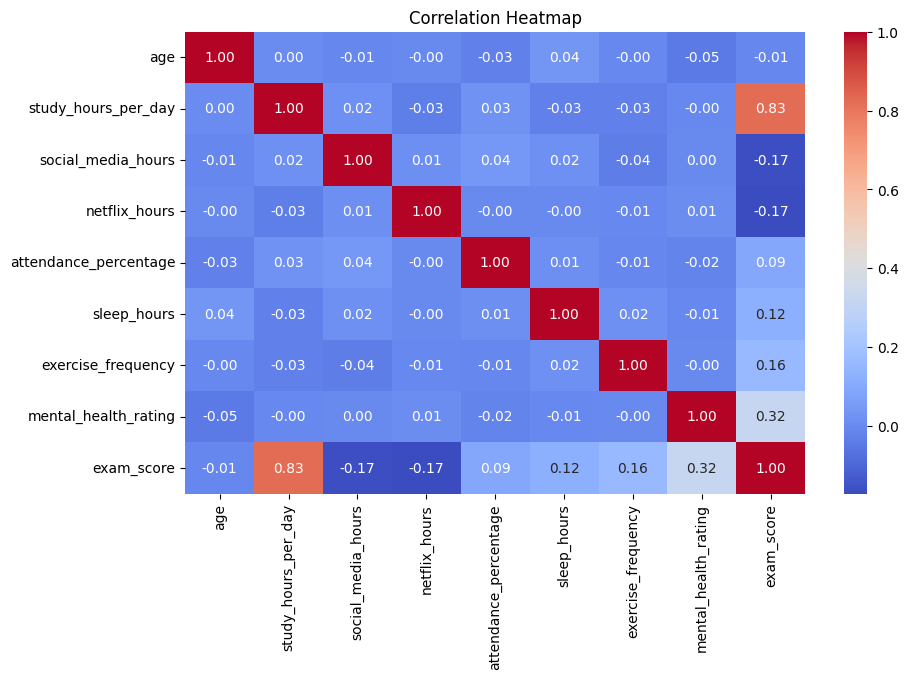

In [11]:
if len(num_cols) > 1:
  plt.figure(figsize=(10,6))
  corr = df[num_cols].corr()
  sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Correlation Heatmap")
  plt.show()

In [ ]:
for col in num_cols:
    fig = px.box(
        df,
        x=col,
        points='all',  # shows all outliers
        title=f'Outlier Visualization: {col}',
        color_discrete_sequence=['#00CC96']
    )
    fig.update_layout(template='plotly_dark')
    fig.show()

In [13]:
df.drop(columns=['student_id'], inplace=True)

In [14]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [38]:
X = df_encoded.drop(columns=['exam_score','mental_health_rating'])
y = df_encoded['exam_score']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
}

In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print(results_df)

                       MAE      RMSE        R2
Ridge             6.277318  7.593406  0.775143
LinearRegression  6.279248  7.593689  0.775127
Lasso             6.285369  7.839062  0.760359
GradientBoosting  6.503022  7.969123  0.752341
RandomForest      6.600937  8.126563  0.742459
XGBoost           6.735848  8.283450  0.732419


In [ ]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
joblib.dump(model, 'exam_score_model.pkl')

['exam_score_model.pkl']

In [36]:
joblib.dump(scaler, 'scaler.pkl')
scaler = joblib.load('scaler.pkl')

In [30]:
loaded_model = joblib.load('exam_score_model.pkl')

In [ ]:
y_pred = loaded_model.predict(X_test_scaled)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.7751265060428243
MAE: 6.279248138596697
